In [ ]:
!pip3 install opencv-python
!pip3 install numpy

Error: Session cannot generate requests

In [3]:
!pip3 install matplotlib

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Overview

Let's overview our problem here ...

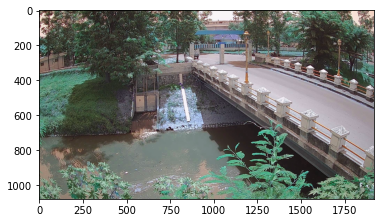

In [11]:
# load sample frame

image = cv2.imread("data/daylight.jpg") # BGR

# display directly in cell
plt.imshow(image)

In [ ]:
# or you can use opencv functionalities in opencv too

cv2.imshow("Preview", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

So our problem is we need to find efficient way to separate water from the rest of the image and measure its level.
First thing that comes into mind is that water maybe did not have any structure/edges

## Explore more techniques that can be used

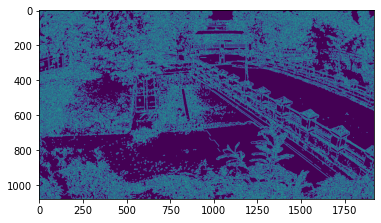

In [3]:
# edge detection using opencv

im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(im_gray, 150, 200, None, 3)

plt.imshow(edges)

from this finding, next possible thing is set up an ROI, because as we can see the road also didnt have any edges

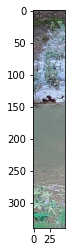

In [21]:
resized_image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)

xmin, ymin = (350, 200)
xmax, ymax = (400, 600)

roi_image = resized_image[ymin:ymax, xmin:xmax]

plt.imshow(roi_image)

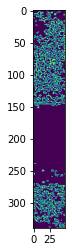

In [22]:
# lets apply previous edge detection

roi_im_gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)

roi_edges = cv2.Canny(roi_im_gray, 150, 200, None, 3)

plt.imshow(roi_edges)

now our job is clear, separate the largest black area from the image, and assume that is water area. We can emply techniques called findCountour in openCV, as I know it's detect white blob from image, so we need to invert our image, so the water is white area

In [23]:
im_inv = cv2.bitwise_not(roi_edges)

dilate = cv2.dilate(im_inv, np.ones(shape=(1, 1), dtype=np.uint8), iterations=1)
erode = cv2.erode(dilate, np.ones(shape=(5, 5), dtype=np.uint8), iterations=1)

contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

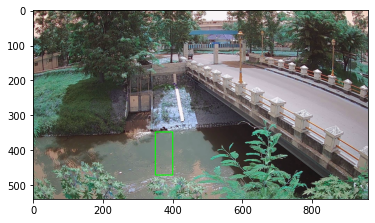

In [24]:
# show the result
im_result = resized_image.copy()

if len(contours) != 0:
    # the contours are drawn here
    cv2.drawContours(erode, contours, -1, 255, 3)

    #find the biggest area of the contour
    c = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(c)

    x += xmin
    y += ymin

    # draw the 'human' contour (in green)
    cv2.rectangle(im_result, (x,y), (x+w,y+h), (0, 255, 0), 2)

plt.imshow(im_result)

voila! we got it right, now with all the information about water area coordinate, I can easily create a function that translates pixel coordinate into level measurement in percentage


In [27]:
def convert_value(src_range, target_range, src_value):
    src_min, src_max = src_range
    target_min, target_max = target_range

    src_dist = src_max - src_min
    target_dist = target_max - target_min

    return (((src_value - src_min) * target_dist) / src_dist) + target_min

# estimate level
y_line_max = 200
y_line_min = 350

water_level_y = min(y_line_min, y)
water_level_perc = 100 - convert_value((y_line_max, y_line_min), (0, 100), water_level_y)

print(water_level_perc)

1.3333333333333286


for better measurement, let slightly rotate the picture so that the water line straight

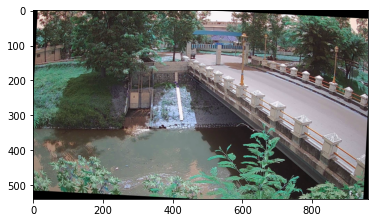

In [30]:
# ROTATING 1.5 DEGREES COUNTER CLOCKWISE
(im_h, im_w) = resized_image.shape[:2]
(cX, cY) = (im_w // 2, im_h // 2)

M = cv2.getRotationMatrix2D((cX, cY), -3, 1.0)
rotated_image = cv2.warpAffine(resized_image, M, (im_w, im_h))

plt.imshow(rotated_image)

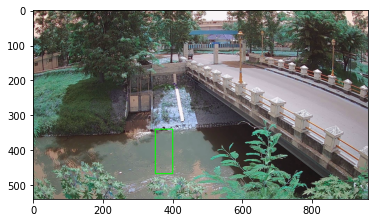

In [31]:
xmin, ymin = (350, 200)
xmax, ymax = (400, 600)

roi_image = rotated_image[ymin:ymax, xmin:xmax]

roi_im_gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)

roi_edges = cv2.Canny(roi_im_gray, 150, 200, None, 3)

im_inv = cv2.bitwise_not(roi_edges)

dilate = cv2.dilate(im_inv, np.ones(shape=(1, 1), dtype=np.uint8), iterations=1)
erode = cv2.erode(dilate, np.ones(shape=(5, 5), dtype=np.uint8), iterations=1)

contours, hierarchy = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# show the result
im_result = resized_image.copy()

if len(contours) != 0:
    # the contours are drawn here
    cv2.drawContours(erode, contours, -1, 255, 3)

    #find the biggest area of the contour
    c = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(c)

    x += xmin
    y += ymin

    # draw the 'human' contour (in green)
    cv2.rectangle(im_result, (x,y), (x+w,y+h), (0, 255, 0), 2)

plt.imshow(im_result)

In [32]:
# estimate level
y_line_max = 200
y_line_min = 350

water_level_y = min(y_line_min, y)
water_level_perc = 100 - convert_value((y_line_max, y_line_min), (0, 100), water_level_y)

print(water_level_perc)

6.666666666666671


## Conclusion

After all of this RnD, we can start to move our code in production. Wrap all necessary image processing into a function that can easily be re-used all across projects, then instead of using single image, replace it to read video stream from RTSP using VideoCapture OpenCV functionality. Last, if you want build the dashboard and setup database that can save historical water percentage over time. Good Luck!